# Projeto: UNB - AutoPark

### O dataset



A preparação dos dados sera feita para que tenhamos todas as informaçoes relevantes de cada uma das imagens em um unico registro. Os metadados de cada uma das imagens estarão reunidados em um unico Dataframe e sera pesistido através de um arquivo CSV.

As imagens do dataset serão processadas para que seu lado de maior dimensão seja receba um redimensionamento para a maior dimensão entre todas do conjunto de dados. Para a dimensão da imagem que não esta na maior possivel do dataset será aplicado um padding com a cor preta. Esta nova imagem será salva em um novo diretório ja pré processada.


Assim cada um dos registros sera feito desta forma:


relative_path   | parkinglot_name | date | weather | status 
--------- | ------ | ------ | ------ | ------ 
str | str | str | str | bool


In [5]:
import os
import ipyplot
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import imutils
DATA_PATH = "/home/delll/fga/veiculos_autonomos/datasets/PKLot/PKLotSegmented"
NEW_DATA_PATH = "/home/delll/fga/veiculos_autonomos/datasets/PKLot/ready2go/"

# Maiores dimensões possiveis na base de dados
bigger_w = 176
bigger_h = 93

In [20]:
def pad_image(img, bigger_w, bigger_h):
    
    padding_sides = (bigger_w - img.shape[0])/ 2
    if(padding_sides.is_integer() ==  False):
        padding_sides = int(padding_sides - 0.5)
    else:
        padding_sides = int(padding_sides)

    padding_top = (bigger_h - img.shape[1])/2    
    if(padding_top.is_integer() ==  False):
        padding_top = int(padding_top - 0.5)
    else:
        padding_top = int(padding_top)

    result = np.ones([bigger_w, bigger_h, 3])
    try:
        result[padding_sides: padding_sides+img.shape[0], padding_top: padding_top + img.shape[1]] = np.array(img)
    except:
        return []
    return result




def read_dataset_dir(parkinglot_name, weather, bigger_w, bigger_h, new_images_path):
    images_path = DATA_PATH + "/"+ parkinglot_name + "/" + weather + "/"

    for date in os.listdir(images_path):
        dir_info_list= []

        for state in os.listdir(images_path + date +"/"):

            for file in os.listdir(images_path + date +"/" + state):
                # path to image file
                
                file_path = images_path + date +"/" + state + "/" + file
                new_file_path = os.path.join(new_images_path , file)

                img = cv2.imread(file_path)
                # make padding and save image
                pw, ph = img.shape[0]/176, img.shape[1]/93
                n_max_size = (110, 58)
                if (pw > ph):
                    img = imutils.resize(img, width=110)
                elif (ph >= pw):
                    img = imutils.resize(img, height=58)
                new_img = pad_image(img, n_max_size[0], n_max_size[1])
                if new_img == []:
                    continue  
                cv2.imwrite(new_file_path, new_img)
                dir_info_list.append([ new_file_path,  parkinglot_name, date, weather,  state ])
                
                # should be changed to a log function
                print("Leitura da imagem com sucesso: ", new_file_path.split("/")[-1],  parkinglot_name, date, weather, state)
    return dir_info_list

In [ ]:
puc_cloudy = read_dataset_dir("PUC", "Cloudy", bigger_w, bigger_h, NEW_DATA_PATH)
puc_sunny = read_dataset_dir("PUC", "Sunny", bigger_w, bigger_h, NEW_DATA_PATH)
puc_rainy = read_dataset_dir("PUC", "Rainy", bigger_w, bigger_h, NEW_DATA_PATH)

UFPR04_cloudy = read_dataset_dir("UFPR04", "Cloudy", bigger_w, bigger_h, NEW_DATA_PATH)
UFPR04_sunny  = read_dataset_dir("UFPR04", "Sunny", bigger_w, bigger_h, NEW_DATA_PATH)
UFPR04_rainy  = read_dataset_dir("UFPR04", "Rainy", bigger_w, bigger_h, NEW_DATA_PATH)            

UFPR05_cloudy = read_dataset_dir("UFPR05", "Cloudy", bigger_w, bigger_h, NEW_DATA_PATH)
UFPR05_sunny = read_dataset_dir("UFPR05", "Sunny", bigger_w, bigger_h, NEW_DATA_PATH)
UFPR05_rainy = read_dataset_dir("UFPR05", "Rainy", bigger_w, bigger_h, NEW_DATA_PATH)


info_list = puc_sunny + puc_cloudy + puc_rainy + UFPR04_cloudy + UFPR04_sunny + UFPR04_rainy + UFPR05_cloudy + UFPR05_sunny + UFPR05_rainy

In [ ]:
df = pd.DataFrame(data=info_list, columns=[ "relative_path", "parkinglot_name", "date", "weather", "status" ])

df = df.sample(frac=1).reset_index(drop=True)

df.to_csv("data.csv")

(110, 58, 3)

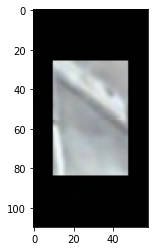

In [97]:
img = cv2.imread(df['relative_path'][3])
plt.imshow(img)
img.shape

# Entendimento dos dados

Após o pré processamento prodemos realizar algumas operações e ferramentas de vizualização para o melhor entendimendo dos dados. Iremos utilizar dos metadados obtidos na etapa anterior deste notebook. Não será necessário o carregamento desta imagens para esta etapa, mas para melhor eficiencia deste notebook iremos carregar as imagens agora. 

In [8]:
df = pd.read_csv("data.csv")


X = []
y = []

for idx, element in enumerate(df.iterrows()):

    img = cv2.imread(element[1]['relative_path'])

    #normalizando as imagens, colocando em um intervalo de 0 a 1
    X.append(img)
    label = 0 if element[1]['status'] == 'Occupied' else 1  
    y.append(label)

## O Dataframe
Agora, com o data frame carregado podemos ver um exemplo de seus primeiros elementos.

In [9]:
df.head(10)

,Unnamed: 0,relative_path,parkinglot_name,date,weather,status
0,0,/home/delll/fga/veiculos_autonomos/datasets/PK...,PUC,2012-11-10,Sunny,Empty
1,1,/home/delll/fga/veiculos_autonomos/datasets/PK...,PUC,2012-10-16,Cloudy,Occupied
2,2,/home/delll/fga/veiculos_autonomos/datasets/PK...,PUC,2012-10-16,Cloudy,Occupied
3,3,/home/delll/fga/veiculos_autonomos/datasets/PK...,UFPR04,2013-01-15,Cloudy,Empty
4,4,/home/delll/fga/veiculos_autonomos/datasets/PK...,PUC,2012-11-09,Rainy,Occupied
5,5,/home/delll/fga/veiculos_autonomos/datasets/PK...,PUC,2012-11-09,Rainy,Occupied
6,6,/home/delll/fga/veiculos_autonomos/datasets/PK...,PUC,2012-11-09,Rainy,Empty
7,7,/home/delll/fga/veiculos_autonomos/datasets/PK...,PUC,2012-11-10,Sunny,Occupied
8,8,/home/delll/fga/veiculos_autonomos/datasets/PK...,PUC,2012-10-16,Cloudy,Empty
9,9,/home/delll/fga/veiculos_autonomos/datasets/PK...,PUC,2012-10-16,Cloudy,Occupied


# Modelo



In [10]:
X_train, X_test = X[0 : int(len(X)*0.75)], X[int(len(X)*0.75): len(X)]
y_train, y_test = y[0 : int(len(y)*0.75)], y[int(len(y)*0.75): len(y)]

In [11]:
X_train, X_test = np.array(X_train), np.array(X_test)
y_train, y_test = np.array(y_train), np.array(y_test)
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(110, 58, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1))
model.add(layers.Activation('sigmoid'))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 108, 56, 16)       448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 54, 28, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 52, 26, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 26, 13, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 10816)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                692288    
_________________________________________________________________
dropout (Dropout)            (None, 64)                0

In [13]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [14]:
history = model.fit(X_train, y_train, epochs=5, 
                    validation_data=(X_test, y_test))

Epoch 1/5
1090/1090 [==============================] - 136s 125ms/step - loss: 0.4717 - accuracy: 0.9381 - val_loss: 0.0114 - val_accuracy: 0.9972
Epoch 2/5
1090/1090 [==============================] - 127s 117ms/step - loss: 0.0920 - accuracy: 0.9755 - val_loss: 0.0638 - val_accuracy: 0.9861
Epoch 3/5
1090/1090 [==============================] - 133s 122ms/step - loss: 0.0851 - accuracy: 0.9751 - val_loss: 0.0627 - val_accuracy: 0.9881
Epoch 4/5
1090/1090 [==============================] - 143s 131ms/step - loss: 0.0683 - accuracy: 0.9791 - val_loss: 0.0108 - val_accuracy: 0.9963
Epoch 5/5
1090/1090 [==============================] - 157s 144ms/step - loss: 0.0300 - accuracy: 0.9926 - val_loss: 0.0061 - val_accuracy: 0.9982


In [17]:
model.save_weights("model.h5")

In [15]:
y_pred = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc = auc(fpr, tpr)

In [34]:
print("Acuracia obtida:", auc)

Acuracia obtida: 0.9999404099963469


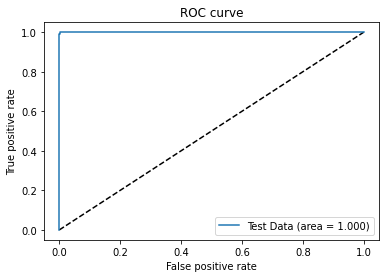

In [16]:
plt.figure(1)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Test Data (area = {:.3f})'.format(auc))
# plt.plot(fpr_train, tpr_train, label='Train Data (area = {:.3f})'.format(auc_train))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()      

In [1]:
# Teste pratico

In [18]:
def prepare_img(file_path):
    img = cv2.imread(file_path)
    # make padding and save image
    pw, ph = img.shape[0]/176, img.shape[1]/93
    n_max_size = (110, 58)
    if (pw > ph):
        img = imutils.resize(img, width=110)
    elif (ph >= pw):
        img = imutils.resize(img, height=58)
    new_img = pad_image(img, n_max_size[0], n_max_size[1])
    
    return new_img

In [109]:
test_image_path = "/home/delll/fga/veiculos_autonomos/datasets/imagens_teste_manual/2.png"

In [110]:
img = cv2.imread(test_image_path)    

pw, ph = img.shape[0]/176, img.shape[1]/93
n_max_size = (110, 58)
if (pw > ph):
    img = imutils.resize(img, height=110)
else:
    img = imutils.resize(img, width=58)
    
padding_sides = (110 - img.shape[0])/ 2
if(padding_sides.is_integer() ==  False):
    padding_sides = int(padding_sides - 0.5)
else:
    padding_sides = int(padding_sides)

padding_top = (58 - img.shape[1])/2    
if(padding_top.is_integer() ==  False):
    padding_top = int(padding_top - 0.5)
else:
    padding_top = int(padding_top)

result = np.ones([110, 58, 3])
result[padding_sides: padding_sides+img.shape[0], padding_top: padding_top + img.shape[1]] = np.array(img)

In [113]:
img.shape

(24, 58, 3)

In [121]:
result = np.ones([110, 58, 3])
result[padding_sides: padding_sides+img.shape[0], padding_top: padding_top + img.shape[1]] = img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


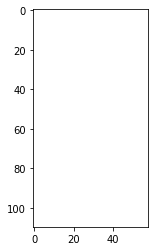

In [123]:
plt.imshow(result)